# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay


## Model Choice

[Explain why you've chosen a particular model as the baseline. This could be a simple statistical model or a basic machine learning model. Justify your choice.]


## Feature Selection

[Indicate which features from the dataset you will be using for the baseline model, and justify your selection.]

--> Using "DP  ALTV ASTV  Mean AC  Variance  LB  MSTV " as these are the features with the highest discrimatory power


In [27]:
%pip install ucimlrepo

# Load the dataset

from ucimlrepo import fetch_ucirepo

# fetch dataset
df = fetch_ucirepo(id=193)

# data (as pandas dataframes)
X = df.data.features
y = df.data.targets

# drop the first column of the y target variable
y = y.iloc[:, 1] # this is the NSP column (Normal, suspect, pathologic)


# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#apply SelectKBest class to extract top 10 best features --> highest discriminatory power
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)


# Combine scores and column names into a single DataFrame
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']

# Select the top 10 features
X_selected = X[featureScores.nlargest(10, 'Score')['Specs']]
# selected features with highest discriminatory power are : DP  ALTV ASTV  Mean  Mode  Median  AC  Variance  LB  MSTV

# Drop the Mode and Median columns form the selected features due to hight correlation with Mean
X_selected = X_selected.drop(['Mode', 'Median'], axis=1)



# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

## Implementation





### Compiling and Training for Logistic Regression

In [28]:
# Function to train logistic regression with optional SMOTE
def train_logistic_regression(X_train, y_train, X_test, apply_smote=False):
    """
    Compiles and trains a logistic regression model with optional SMOTE.

    Parameters:
    X_train: Training features
    y_train: Training labels
    X_test: Test features (used for scaling)
    apply_smote: Whether to apply SMOTE to balance the training data

    Returns:
    model: Trained logistic regression model
    X_test_scaled: Scaled test features
    """
    # Step 1: Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 2: Apply SMOTE if required
    if apply_smote:
        smote = SMOTE(random_state=42)
        X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

    # Step 3: Initialize logistic regression model
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )

    # Step 4: Train the model
    model.fit(X_train_scaled, y_train)

    return model, X_test_scaled

# Function to train logistic regression with class_weight
def train_logistic_regression_with_class_weight(X_train, y_train, X_test):
    """
    Compiles and trains a logistic regression model with class weights.

    Parameters:
    X_train: Training features
    y_train: Training labels
    X_test: Test features (used for scaling)

    Returns:
    model: Trained logistic regression model
    X_test_scaled: Scaled test features
    """
    # Step 1: Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 2: Initialize logistic regression model with class_weight
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        class_weight='balanced'  # Automatically adjusts weights based on class frequencies
    )

    # Step 3: Train the model
    model.fit(X_train_scaled, y_train)

    return model, X_test_scaled


# Train the model with SMOTE
model_smote, X_test_smote = train_logistic_regression(X_train, y_train, X_test, apply_smote=True)

# Train the model without SMOTE but with class_weight
model_no_smote_weighted, X_test_no_smote_weighted = train_logistic_regression_with_class_weight(X_train, y_train, X_test)

# Train the model without SMOTE and without class_weight
model_no_smote, X_test_no_smote = train_logistic_regression(X_train, y_train, X_test, apply_smote=False)




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Compiling and Training for Support Vector Machine

In [29]:
def train_svm_with_optimized_kernel(X_train, y_train, X_test, kernel='rbf', tune_hyperparameters=False):
    """
    Trains a Support Vector Machine (SVM) model with class weights and optional hyperparameter tuning.

    Parameters:
    X_train: Training features
    y_train: Training labels
    X_test: Test features (used for scaling)
    kernel: Kernel type to use ('linear', 'rbf', 'poly', 'sigmoid')
    tune_hyperparameters: Whether to perform hyperparameter tuning using GridSearchCV

    Returns:
    model: Trained SVM model
    X_test_scaled: Scaled test features
    """
    # Step 1: Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 2: Initialize SVM with class_weight
    svm_model = SVC(
        kernel=kernel,
        probability=True,
        random_state=42,
        class_weight='balanced'
    )

    # Step 3: Hyperparameter tuning
    if tune_hyperparameters:
        # Different parameter grids depending on kernel type
        if kernel == 'linear':
            param_grid = {
                'C': [0.1, 1, 10, 100],  # Only C parameter for linear kernel
                'kernel': [kernel]
            }
        else:
            param_grid = {
                'C': [0.1, 1, 10, 100],  # Regularization parameter
                'gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient
                'kernel': [kernel]
            }

        grid_search = GridSearchCV(svm_model, param_grid, cv=3, scoring='f1_weighted', verbose=2)
        grid_search.fit(X_train_scaled, y_train)
        svm_model = grid_search.best_estimator_

    # Step 4: Train the model
    svm_model.fit(X_train_scaled, y_train)

    return svm_model, X_test_scaled



In [30]:
# Train the SVM model with optimized kernel
# Specify the kernel you want to use and whether to enable hyperparameter tuning
svm_model, X_test_svm = train_svm_with_optimized_kernel(X_train, y_train, X_test, kernel='rbf', tune_hyperparameters=True)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.6s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.4s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.4s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.4s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.6s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.7s
[CV] END .....................C=0.1, gamma=0.001

In [31]:
# Train the linear SVM model
linear_svm_model, X_test_linear = train_svm_with_optimized_kernel(X_train, y_train, X_test, kernel='linear', tune_hyperparameters=True)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   0.1s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.1s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.1s
[CV] END .................................C=1, kernel=linear; total time=   0.1s
[CV] END .................................C=1, kernel=linear; total time=   0.1s
[CV] END .................................C=1, kernel=linear; total time=   0.1s
[CV] END ................................C=10, kernel=linear; total time=   0.1s
[CV] END ................................C=10, kernel=linear; total time=   0.2s
[CV] END ................................C=10, kernel=linear; total time=   0.1s
[CV] END ...............................C=100, kernel=linear; total time=   0.8s
[CV] END ...............................C=100, kernel=linear; total time=   1.0s
[CV] END ...............................C=100, ke

# Evaluation

## Metrics to Evaluate the Model

### Primary Metrics
- **Recall**: Ensure no pathological cases are missed (focus on sensitivity).
- **F1-Score**: Balances Precision and Recall for each class.
- **Confusion Matrix**: Analyze detailed classification errors.

### Secondary Metrics
- **Accuracy**: Provides an overall performance snapshot but is less reliable for imbalanced datasets.
- **Precision**: Evaluate the proportion of correct positive predictions to avoid excessive false alarms.

### Advanced Metric
- **ROC-AUC**: Measure the model’s ability to distinguish between classes, useful for comparing models or optimizing thresholds.


## Evaluation Logistic Regression

In [32]:
# Funktion zur Evaluation und Visualisierung der Modelle
def evaluate_and_visualize_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluates and visualizes the performance of a model.

    Parameters:
    model: Trained model to evaluate
    X_test: Test features
    y_test: True labels for the test set
    model_name: Name of the model (e.g., "SVM with SMOTE")
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Berechne Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.2f}")

    # Classification report
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, target_names=["Normal", "Suspect", "Pathologic"], output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report)

    # Visualisiere den Klassifikationsbericht als Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_report.iloc[:-3, :3], annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
    plt.title(f"Precision, Recall, and F1-Score ({model_name} Heatmap Table)")
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.show()

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Normal", "Suspect", "Pathologic"])
    disp.plot(cmap="viridis")
    plt.title(f"Confusion Matrix ({model_name})")
    plt.show()

    # Plot ROC curves if probabilities are enabled
    if hasattr(model, "predict_proba") and callable(model.predict_proba):
        y_proba = model.predict_proba(X_test)
        plt.figure(figsize=(10, 8))

        # Compute ROC curve and AUC for each class
        for i, class_label in enumerate(["Normal", "Suspect", "Pathologic"]):
            fpr, tpr, _ = roc_curve(y_test == i + 1, y_proba[:, i])
            auc = roc_auc_score(y_test == i + 1, y_proba[:, i])
            plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc:.2f})")

        # Add diagonal line for random guess
        plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

        plt.title(f"ROC Curves for Each Class ({model_name})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()
    else:
        print(f"Probability estimates are not available for {model_name}.")

### Evaluation Logistic Regression with SMOTE


--- Logistic Regression with SMOTE ---
Accuracy: 0.85

Classification Report:
              precision    recall  f1-score     support
Normal         0.986063  0.849850  0.912903  333.000000
Suspect        0.561224  0.859375  0.679012   64.000000
Pathologic     0.585366  0.827586  0.685714   29.000000
accuracy       0.849765  0.849765  0.849765    0.849765
macro avg      0.710884  0.845604  0.759210  426.000000
weighted avg   0.894960  0.849765  0.862299  426.000000


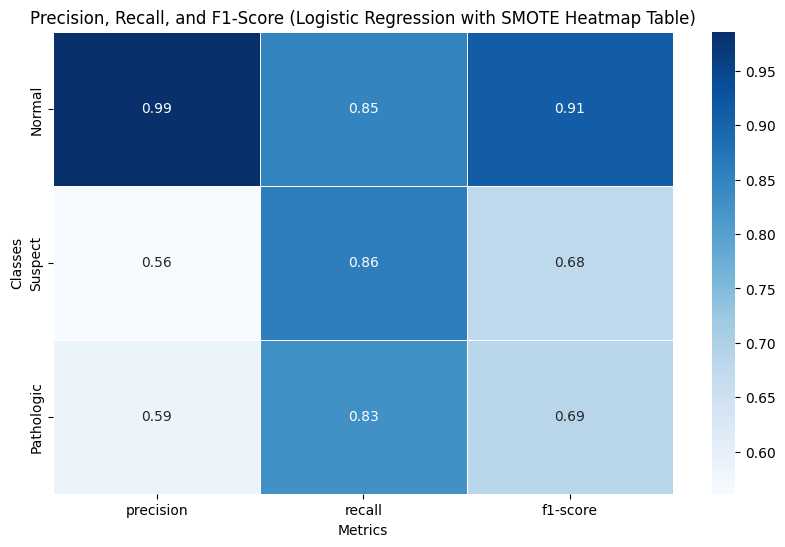

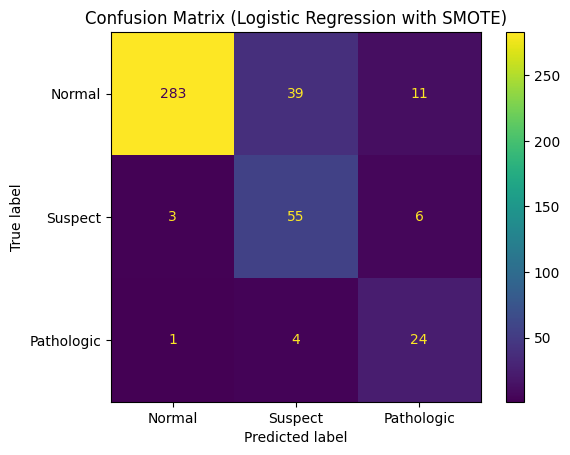

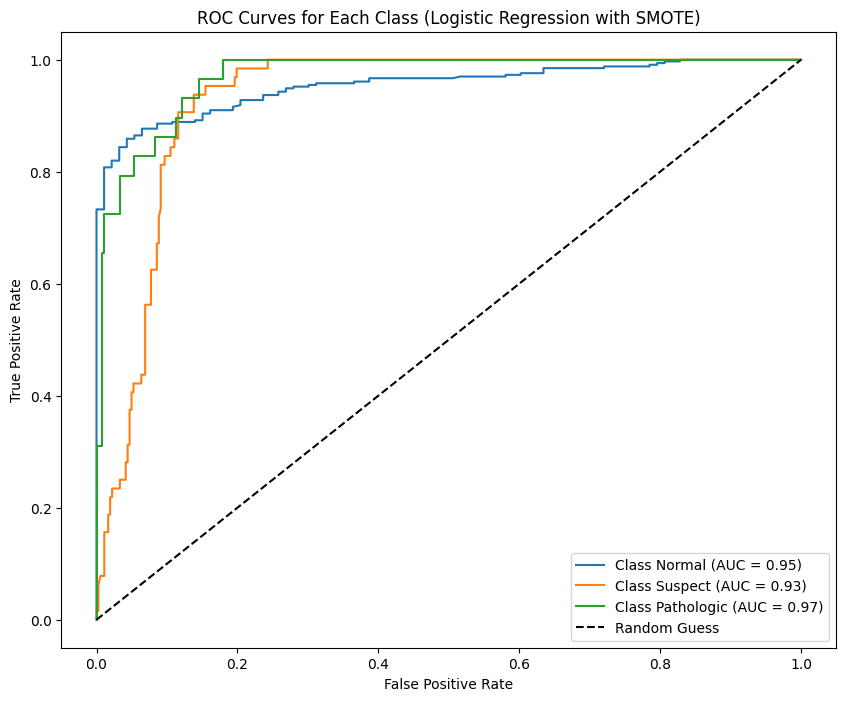

In [33]:
# Evaluate and visualize the model trained with SMOTE
evaluate_and_visualize_model(model_smote, X_test_smote, y_test, model_name="Logistic Regression with SMOTE")


### Evaluation Logistic Regression with class_weight


--- Logistic Regression with class_weight ---
Accuracy: 0.85

Classification Report:
              precision    recall  f1-score    support
Normal         0.989362  0.837838  0.907317  333.00000
Suspect        0.549020  0.875000  0.674699   64.00000
Pathologic     0.595238  0.862069  0.704225   29.00000
accuracy       0.845070  0.845070  0.845070    0.84507
macro avg      0.711206  0.858302  0.762080  426.00000
weighted avg   0.896377  0.845070  0.858544  426.00000


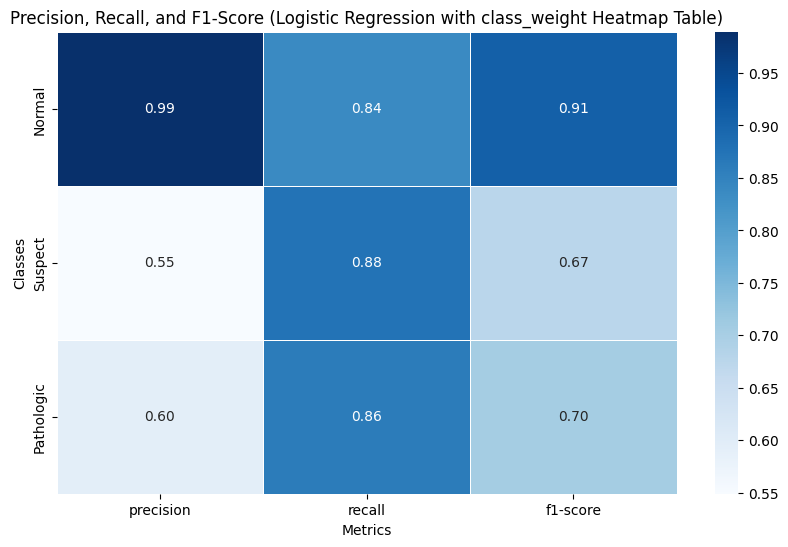

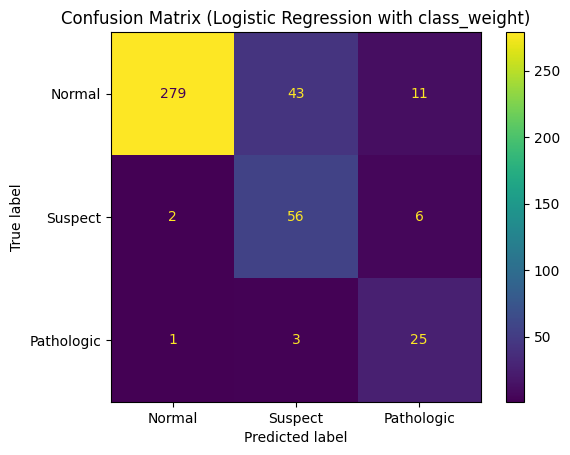

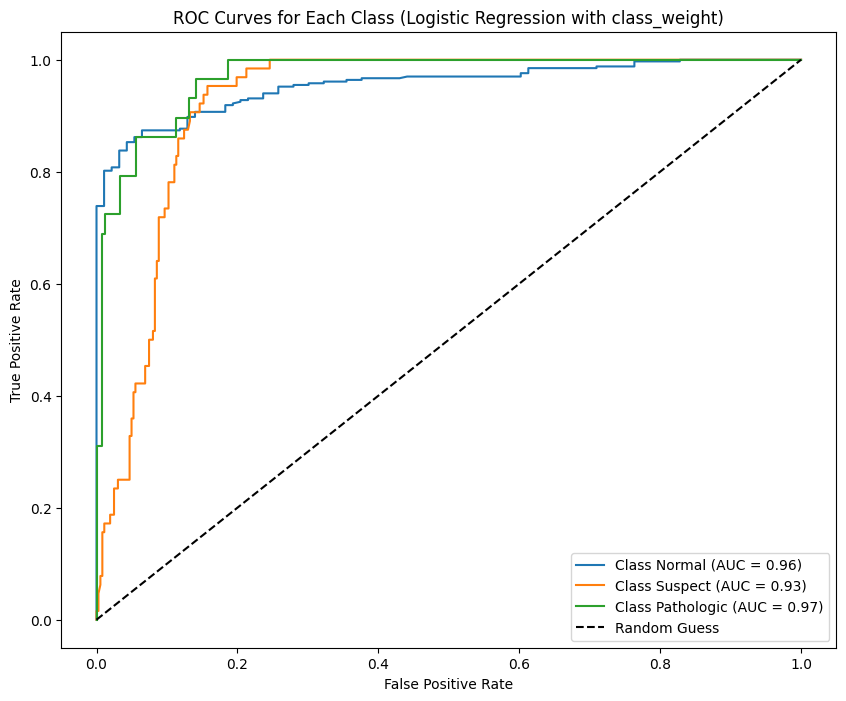

In [34]:
# Evaluate and visualize the model trained with class_weight
evaluate_and_visualize_model(model_no_smote_weighted, X_test_no_smote_weighted, y_test, model_name="Logistic Regression with class_weight")

### Evaluation Logistic Regression without SMOTE and withou class_weight


--- Logistic Regression without SMOTE and without class_weight ---
Accuracy: 0.88

Classification Report:
              precision    recall  f1-score     support
Normal         0.931548  0.939940  0.935725  333.000000
Suspect        0.661290  0.640625  0.650794   64.000000
Pathologic     0.750000  0.724138  0.736842   29.000000
accuracy       0.880282  0.880282  0.880282    0.880282
macro avg      0.780946  0.768234  0.774454  426.000000
weighted avg   0.878587  0.880282  0.879379  426.000000


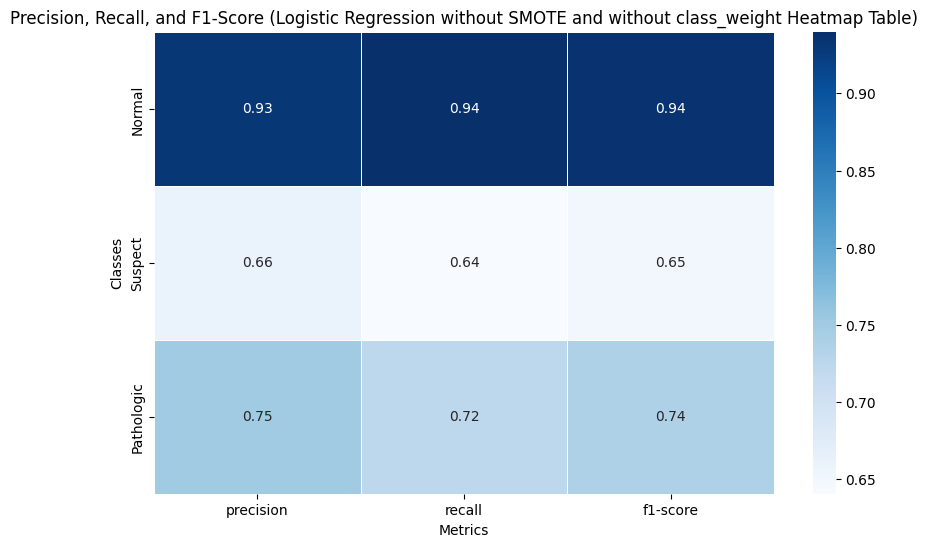

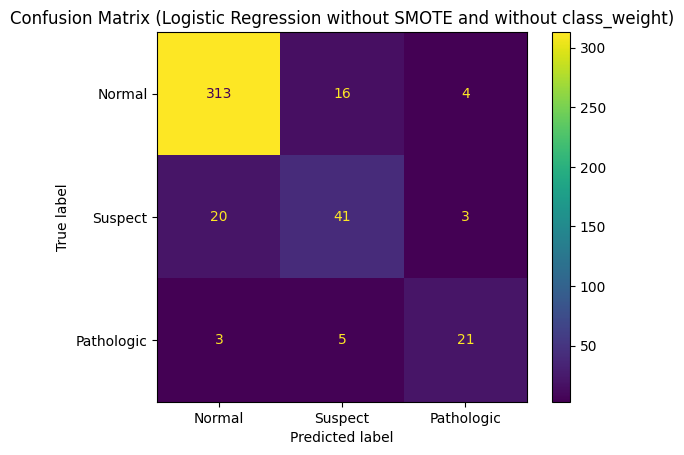

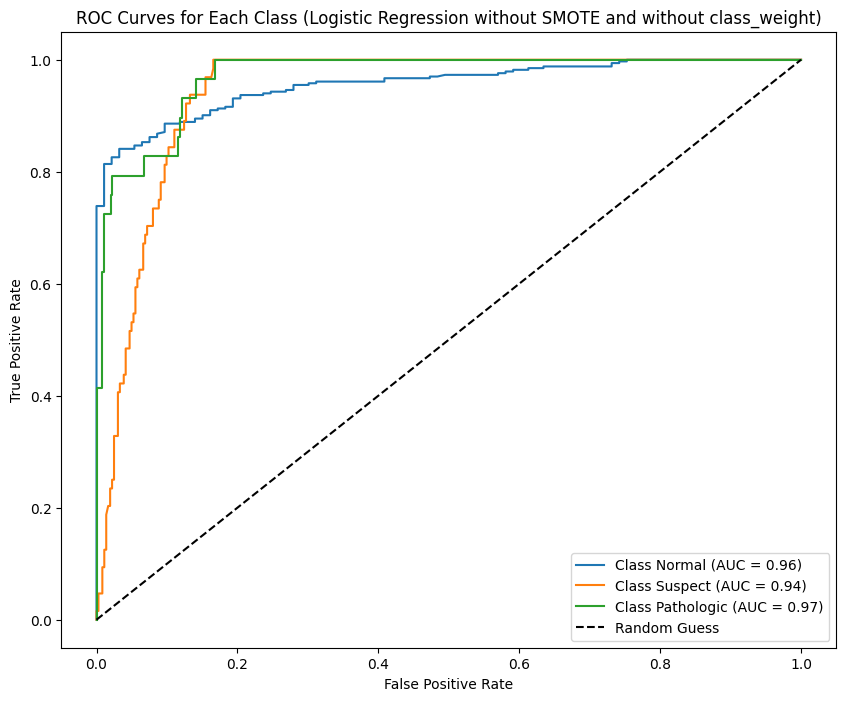

In [35]:
# Evaluate and visualize the model trained without class_weight and without SMOTE
evaluate_and_visualize_model(model_no_smote, X_test_no_smote, y_test, model_name="Logistic Regression without SMOTE and without class_weight")

## Evaluation Support Vector Machine

### Evaluation Support Vectoe Machine with Non-Linear Kernel (rbf)


--- SVM with Optimized Kernel ---
Accuracy: 0.90

Classification Report:
              precision    recall  f1-score     support
Normal         0.983819  0.912913  0.947040  333.000000
Suspect        0.647727  0.890625  0.750000   64.000000
Pathologic     0.827586  0.827586  0.827586   29.000000
accuracy       0.903756  0.903756  0.903756    0.903756
macro avg      0.819711  0.877041  0.841542  426.000000
weighted avg   0.922691  0.903756  0.909306  426.000000


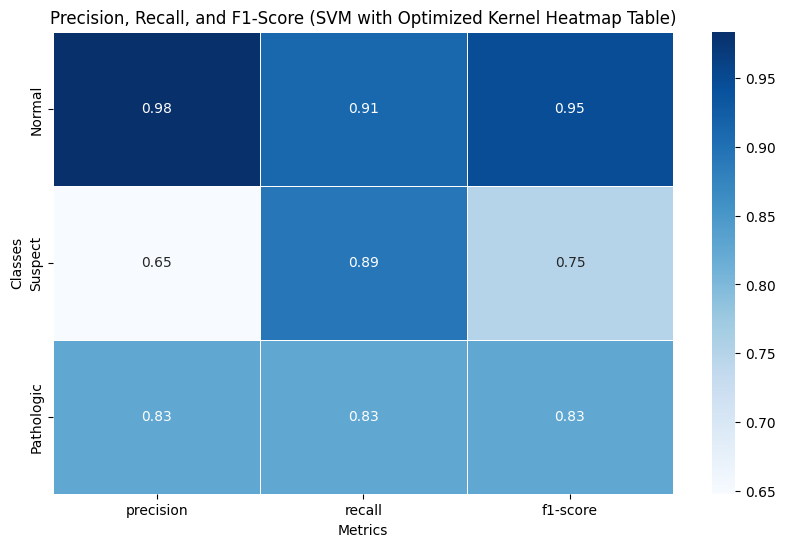

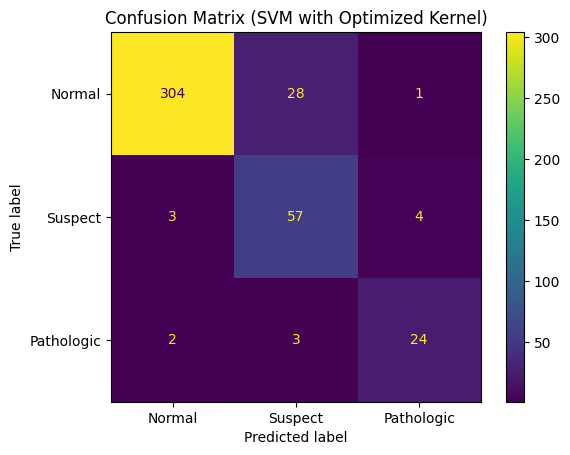

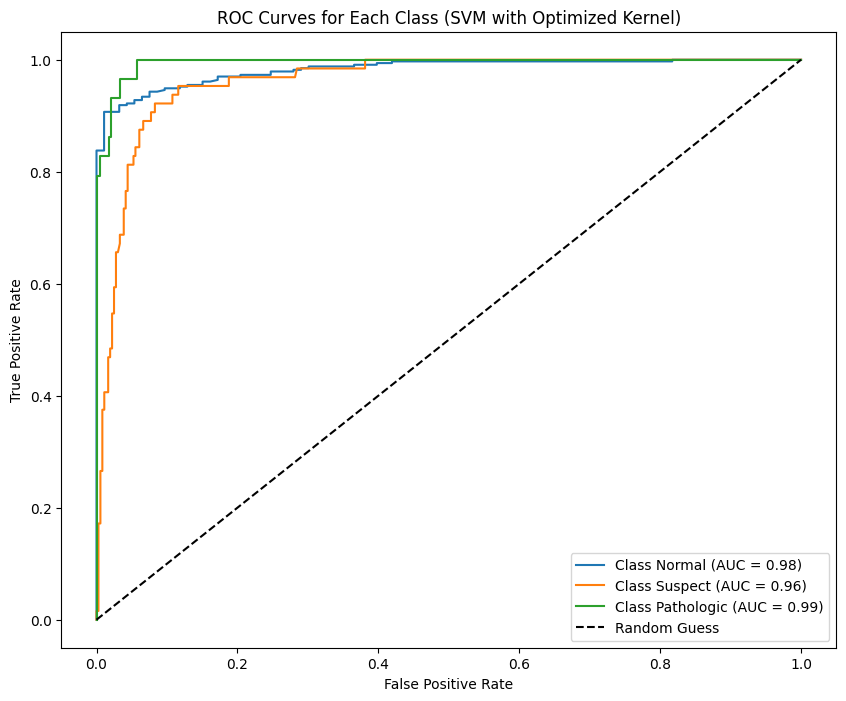

In [36]:
# Evaluate the SVM model with the non-linear kernel
evaluate_and_visualize_model(svm_model, X_test_svm, y_test, model_name="SVM with Optimized Kernel")



--- SVM with Linear Kernel ---
Accuracy: 0.84

Classification Report:
              precision    recall  f1-score     support
Normal         0.989362  0.837838  0.907317  333.000000
Suspect        0.530000  0.828125  0.646341   64.000000
Pathologic     0.545455  0.827586  0.657534   29.000000
accuracy       0.835681  0.835681  0.835681    0.835681
macro avg      0.688272  0.831183  0.737064  426.000000
weighted avg   0.890131  0.835681  0.851105  426.000000


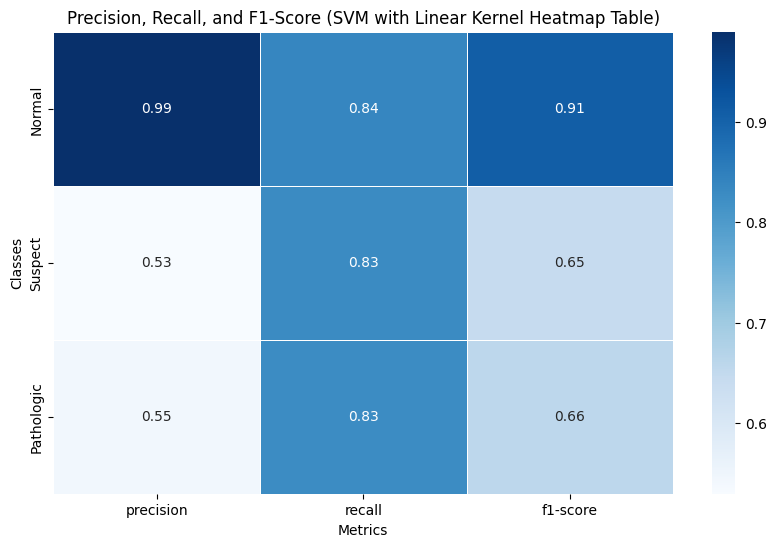

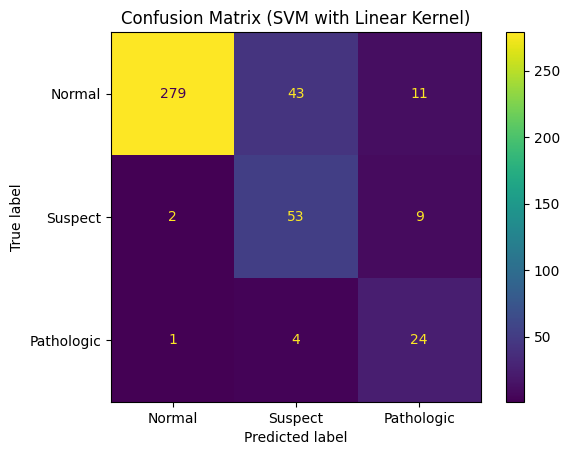

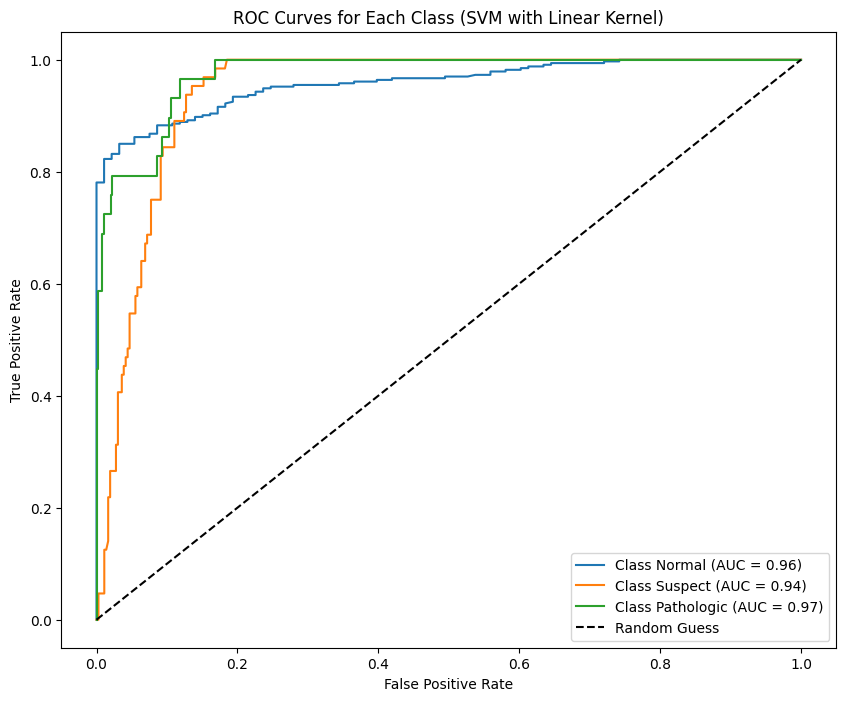

In [37]:
# Evaluate the linear SVM model
evaluate_and_visualize_model(linear_svm_model, X_test_linear, y_test, model_name="SVM with Linear Kernel")

## Comparing Logistic Regression (with class_weight) and Support Vector Machine (kernel='rbf')

In [38]:
def compare_models(X_train, y_train, X_test, y_test):
    """
    Trains and compares SVM and Logistic Regression models.
    Returns the comparison metrics and creates visualization plots.
    """
    # Train Logistic Regression with class weights
    logreg_model, X_test_logreg = train_logistic_regression_with_class_weight(X_train, y_train, X_test)

    # Train SVM with RBF kernel
    svm_model, X_test_svm = train_svm_with_optimized_kernel(
        X_train, y_train, X_test,
        kernel='rbf',
        tune_hyperparameters=False
    )

    # Get predictions
    y_pred_logreg = logreg_model.predict(X_test_logreg)
    y_pred_svm = svm_model.predict(X_test_svm)

    # Get classification reports
    report_logreg = classification_report(y_test, y_pred_logreg,
                                        target_names=["Normal", "Suspect", "Pathologic"],
                                        output_dict=True)
    report_svm = classification_report(y_test, y_pred_svm,
                                     target_names=["Normal", "Suspect", "Pathologic"],
                                     output_dict=True)

    # Create comparison DataFrame with consistent naming
    comparison_data = {
        'precision_LogReg': [report_logreg[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        'recall_LogReg': [report_logreg[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        'f1-score_LogReg': [report_logreg[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]],
        'precision_SVM': [report_svm[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        'recall_SVM': [report_svm[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        'f1-score_SVM': [report_svm[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]]
    }

    comparison_df = pd.DataFrame(comparison_data,
                               index=["Normal", "Suspect", "Pathologic"])

    # Create visualization
    metrics = ["Precision", "Recall", "F1-Score"]
    classes = comparison_df.index
    x = np.arange(len(classes))
    width = 0.35

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for i, metric in enumerate(metrics):
        # Handle column names correctly
        if metric == "F1-Score":
            logreg_values = comparison_df['f1-score_LogReg']
            svm_values = comparison_df['f1-score_SVM']
        else:
            logreg_values = comparison_df[f'{metric.lower()}_LogReg']
            svm_values = comparison_df[f'{metric.lower()}_SVM']

        ax = axes[i]
        rects1 = ax.bar(x - width/2, logreg_values, width, label='Logistic Regression',
                       color='skyblue', alpha=0.8)
        rects2 = ax.bar(x + width/2, svm_values, width, label='SVM',
                       color='lightcoral', alpha=0.8)

        ax.set_title(metric)
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.set_ylabel("Score")
        ax.set_ylim(0, 1)
        ax.legend()

        # Add value labels on bars
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}',
                          xy=(rect.get_x() + rect.get_width()/2, height),
                          xytext=(0, 3),
                          textcoords="offset points",
                          ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

    fig.suptitle("Comparison of Metrics: Logistic Regression vs. SVM", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Print summary statistics
    print("\nModel Comparison Summary:")
    print("\nLogistic Regression Weighted Average Metrics:")
    print(f"Precision: {report_logreg['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_logreg['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_logreg['weighted avg']['f1-score']:.3f}")

    print("\nSVM Weighted Average Metrics:")
    print(f"Precision: {report_svm['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_svm['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_svm['weighted avg']['f1-score']:.3f}")

    return comparison_df



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


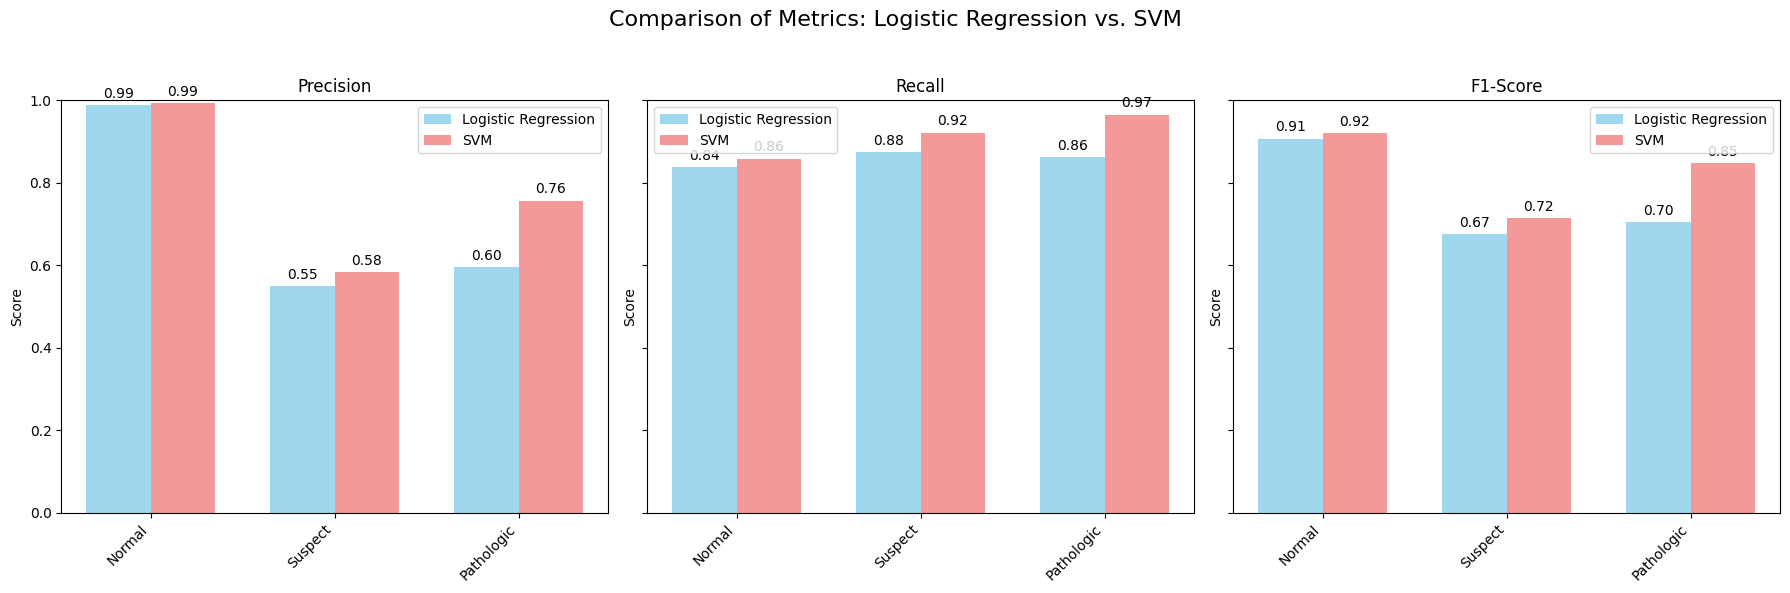


Model Comparison Summary:

Logistic Regression Weighted Average Metrics:
Precision: 0.896
Recall: 0.845
F1-Score: 0.859

SVM Weighted Average Metrics:
Precision: 0.916
Recall: 0.876
F1-Score: 0.885


In [39]:
# Use the comparison function
comparison_results = compare_models(X_train, y_train, X_test, y_test)

# Analysing the Importance of the Included Features

## Logistic Regression

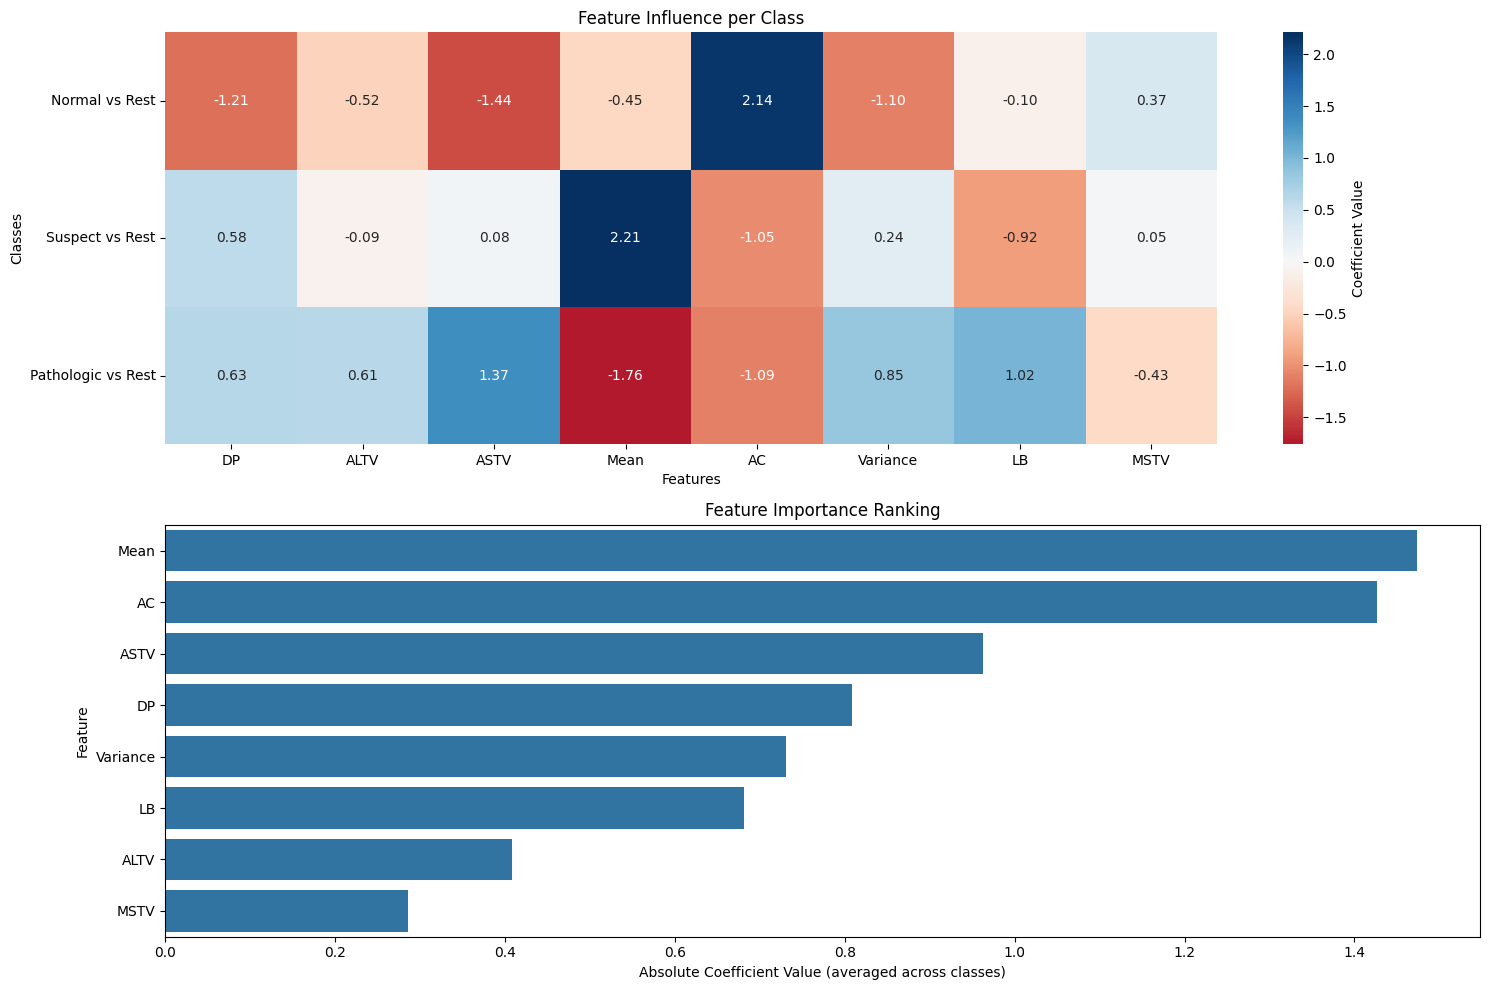


Feature Importance Ranking:
Mean: 1.4741
AC: 1.4261
ASTV: 0.9622
DP: 0.8081
Variance: 0.7304
LB: 0.6814
ALTV: 0.4081
MSTV: 0.2859

Feature Influence per Class:

Normal:
Top positive indicators:
AC: +2.1391
MSTV: +0.3742
Top negative indicators:
ASTV: -1.4433
DP: -1.2122
Variance: -1.0956

Suspect:
Top positive indicators:
Mean: +2.2111
DP: +0.5773
Variance: +0.2431
Top negative indicators:
AC: -1.0461
LB: -0.9207
ALTV: -0.0947

Pathologic:
Top positive indicators:
ASTV: +1.3682
LB: +1.0222
Variance: +0.8525
Top negative indicators:
Mean: -1.7601
AC: -1.0931
MSTV: -0.4289


In [40]:
# Define feature names
feature_names = ['DP', 'ALTV', 'ASTV', 'Mean', 'AC', 'Variance', 'LB', 'MSTV']

def analyze_features(model, feature_names):
    """
    Analyzes feature importance from a trained logistic regression model.

    Parameters:
    model: Trained logistic regression model
    feature_names: List of feature names

    Returns:
    coef_df: DataFrame with coefficients per class
    importance_df: DataFrame with overall feature importance
    """
    # Get coefficients per class
    coef_df = pd.DataFrame(
        model.coef_,
        columns=feature_names,
        index=['Normal vs Rest', 'Suspect vs Rest', 'Pathologic vs Rest']
    )

    # Calculate overall feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Absolute Importance': np.abs(model.coef_).mean(axis=0)
    }).sort_values('Absolute Importance', ascending=False)

    # Visualizations
    plt.figure(figsize=(15, 10))

    # 1. Feature coefficients heatmap
    plt.subplot(2, 1, 1)
    sns.heatmap(coef_df, cmap='RdBu', center=0, annot=True, fmt='.2f',
                cbar_kws={'label': 'Coefficient Value'})
    plt.title('Feature Influence per Class')
    plt.xlabel('Features')
    plt.ylabel('Classes')

    # 2. Overall feature importance
    plt.subplot(2, 1, 2)
    sns.barplot(data=importance_df, x='Absolute Importance', y='Feature')
    plt.title('Feature Importance Ranking')
    plt.xlabel('Absolute Coefficient Value (averaged across classes)')

    plt.tight_layout()
    plt.show()

    # Print feature importance ranking
    print("\nFeature Importance Ranking:")
    for idx, row in importance_df.iterrows():
        print(f"{row['Feature']}: {row['Absolute Importance']:.4f}")

    # Print class-specific feature influence
    print("\nFeature Influence per Class:")
    for i, class_name in enumerate(['Normal', 'Suspect', 'Pathologic']):
        coef = model.coef_[i]
        feat_importance = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coef
        }).sort_values('Coefficient', key=abs, ascending=False)

        print(f"\n{class_name}:")
        print("Top positive indicators:")
        positive = feat_importance[feat_importance['Coefficient'] > 0].head(3)
        for _, row in positive.iterrows():
            print(f"{row['Feature']}: +{row['Coefficient']:.4f}")

        print("Top negative indicators:")
        negative = feat_importance[feat_importance['Coefficient'] < 0].head(3)
        for _, row in negative.iterrows():
            print(f"{row['Feature']}: {row['Coefficient']:.4f}")

    return coef_df, importance_df

# Run analysis for weighted model
coef_df, importance_df = analyze_features(model_no_smote_weighted, feature_names)


## Support Vector Machine (Linear)

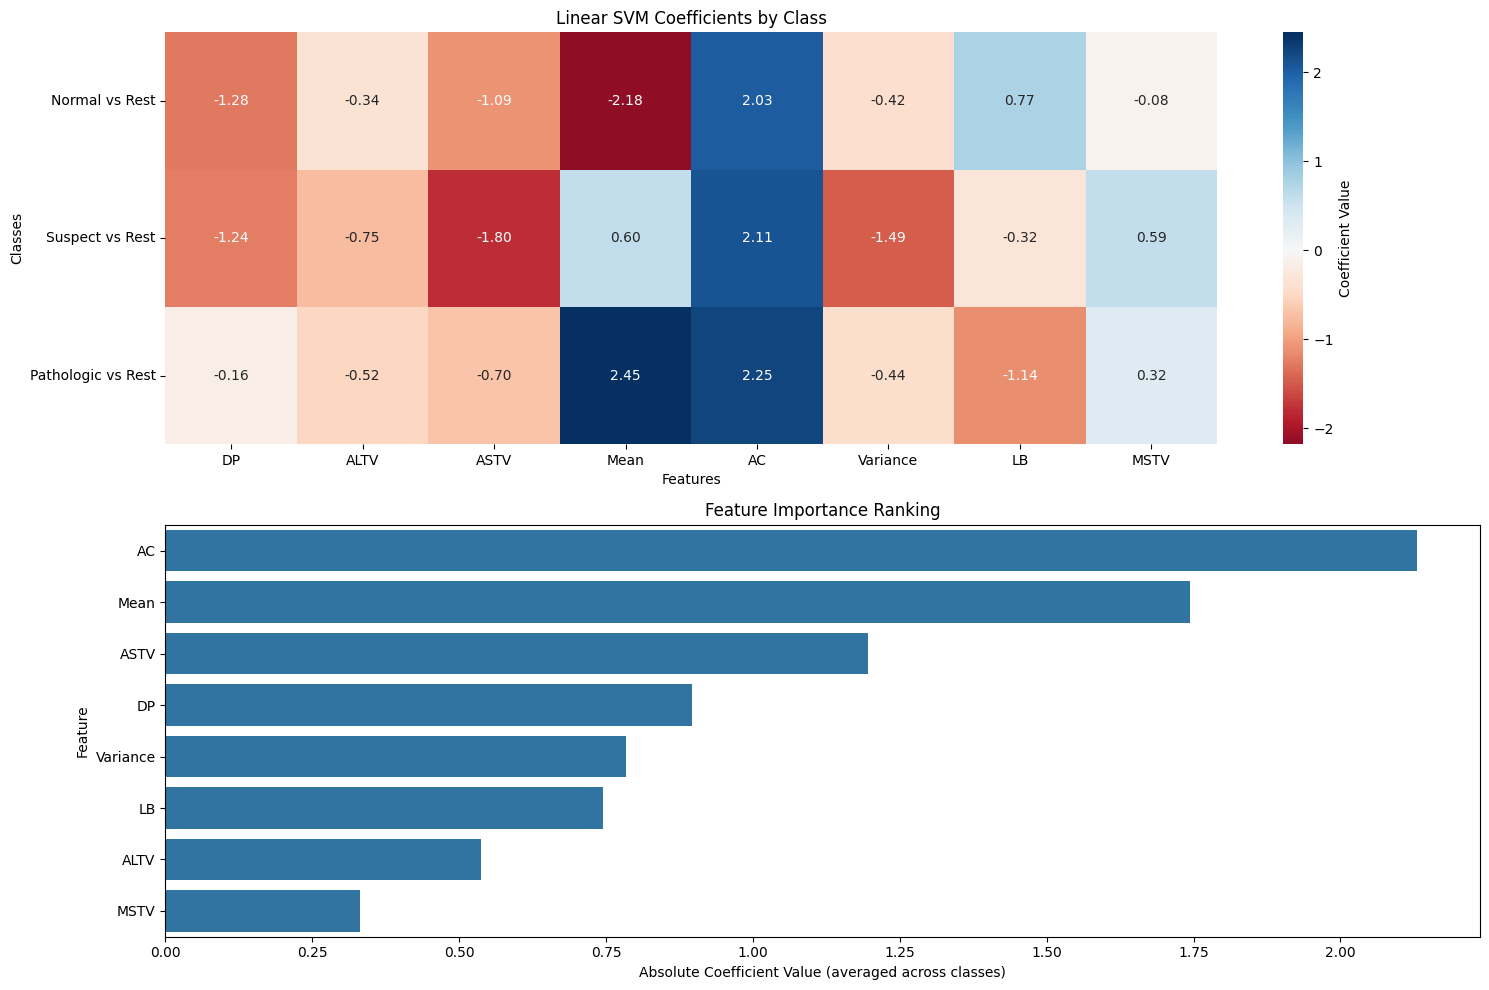


Feature Importance Ranking:
AC: 2.1310
Mean: 1.7442
ASTV: 1.1951
DP: 0.8961
Variance: 0.7834
LB: 0.7445
ALTV: 0.5377
MSTV: 0.3311

Feature Influence per Class:

Normal:
Top positive indicators:
AC: +2.0312
LB: +0.7733
Top negative indicators:
Mean: -2.1823
DP: -1.2847
ASTV: -1.0904

Suspect:
Top positive indicators:
AC: +2.1133
Mean: +0.5998
MSTV: +0.5878
Top negative indicators:
ASTV: -1.7973
Variance: -1.4910
DP: -1.2437

Pathologic:
Top positive indicators:
Mean: +2.4505
AC: +2.2486
MSTV: +0.3220
Top negative indicators:
LB: -1.1423
ASTV: -0.6975
ALTV: -0.5229


In [41]:
def analyze_linear_svm_features(model, feature_names):
    """
    Analyzes feature importance from a trained linear SVM model.

    Parameters:
    model: Trained linear SVM model
    feature_names: List of feature names

    Returns:
    coef_df: DataFrame with coefficients per class
    importance_df: DataFrame with overall feature importance
    """
    # Get coefficients per class
    coef_df = pd.DataFrame(
        model.coef_,
        columns=feature_names,
        index=['Normal vs Rest', 'Suspect vs Rest', 'Pathologic vs Rest']
    )

    # Calculate overall feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Absolute Importance': np.abs(model.coef_).mean(axis=0)
    }).sort_values('Absolute Importance', ascending=False)

    # Visualizations
    plt.figure(figsize=(15, 10))

    # 1. Feature coefficients heatmap
    plt.subplot(2, 1, 1)
    sns.heatmap(coef_df, cmap='RdBu', center=0, annot=True, fmt='.2f',
                cbar_kws={'label': 'Coefficient Value'})
    plt.title('Linear SVM Coefficients by Class')
    plt.xlabel('Features')
    plt.ylabel('Classes')

    # 2. Overall feature importance
    plt.subplot(2, 1, 2)
    sns.barplot(data=importance_df, x='Absolute Importance', y='Feature')
    plt.title('Feature Importance Ranking')
    plt.xlabel('Absolute Coefficient Value (averaged across classes)')

    plt.tight_layout()
    plt.show()

    # Print feature importance ranking
    print("\nFeature Importance Ranking:")
    for idx, row in importance_df.iterrows():
        print(f"{row['Feature']}: {row['Absolute Importance']:.4f}")

    # Print class-specific feature influence
    print("\nFeature Influence per Class:")
    for i, class_name in enumerate(['Normal', 'Suspect', 'Pathologic']):
        coef = model.coef_[i]
        feat_importance = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coef
        }).sort_values('Coefficient', key=abs, ascending=False)

        print(f"\n{class_name}:")
        print("Top positive indicators:")
        positive = feat_importance[feat_importance['Coefficient'] > 0].head(3)
        for _, row in positive.iterrows():
            print(f"{row['Feature']}: +{row['Coefficient']:.4f}")

        print("Top negative indicators:")
        negative = feat_importance[feat_importance['Coefficient'] < 0].head(3)
        for _, row in negative.iterrows():
            print(f"{row['Feature']}: {row['Coefficient']:.4f}")

    return coef_df, importance_df

# Define feature names
feature_names = ['DP', 'ALTV', 'ASTV', 'Mean', 'AC', 'Variance', 'LB', 'MSTV']

# Run the analysis
coefficients, importance = analyze_linear_svm_features(linear_svm_model, feature_names)


## Comparing Feature Importance for Logistic Regression and Support Vector Machine (Linear)

In [ ]:
def compare_feature_importance(logreg_model, svm_model, feature_names):
    """
    Compares feature importance between logistic regression and linear SVM.

    Parameters:
    logreg_model: Trained logistic regression model
    svm_model: Trained linear SVM model
    feature_names: List of feature names
    """
    # Get coefficients for both models
    logreg_coef = pd.DataFrame(
        logreg_model.coef_,
        columns=feature_names,
        index=['Normal vs Rest', 'Suspect vs Rest', 'Pathologic vs Rest']
    )

    svm_coef = pd.DataFrame(
        svm_model.coef_,
        columns=feature_names,
        index=['Normal vs Rest', 'Suspect vs Rest', 'Pathologic vs Rest']
    )

    # Calculate overall importance for both models
    logreg_importance = pd.DataFrame({
        'Feature': feature_names,
        'Absolute Importance': np.abs(logreg_model.coef_).mean(axis=0),
        'Model': 'Logistic Regression'
    }).sort_values('Absolute Importance', ascending=False)

    svm_importance = pd.DataFrame({
        'Feature': feature_names,
        'Absolute Importance': np.abs(svm_model.coef_).mean(axis=0),
        'Model': 'Linear SVM'
    }).sort_values('Absolute Importance', ascending=False)

    # Combine importance scores
    combined_importance = pd.concat([logreg_importance, svm_importance])

    # Visualizations
    plt.figure(figsize=(15, 15))

    # 1. Coefficient comparison heatmap
    plt.subplot(2, 1, 1)
    comparison_df = pd.DataFrame({
        'LogReg': np.abs(logreg_model.coef_).mean(axis=0),
        'SVM': np.abs(svm_model.coef_).mean(axis=0)
    }, index=feature_names)

    sns.heatmap(comparison_df, cmap='YlOrRd', annot=True, fmt='.2f',
                cbar_kws={'label': 'Absolute Coefficient Value'})
    plt.title('Feature Importance Comparison: Logistic Regression vs Linear SVM')

    # 2. Side-by-side barplot
    plt.subplot(2, 1, 2)
    sns.barplot(data=combined_importance, x='Absolute Importance', y='Feature',
                hue='Model', palette=['skyblue', 'lightcoral'])
    plt.title('Feature Importance Ranking Comparison')
    plt.xlabel('Absolute Coefficient Value (averaged across classes)')

    plt.tight_layout()
    plt.show()

    # Print comparison
    print("\nFeature Importance Comparison:")
    comparison = pd.DataFrame({
        'Feature': feature_names,
        'LogReg_Importance': np.abs(logreg_model.coef_).mean(axis=0),
        'SVM_Importance': np.abs(svm_model.coef_).mean(axis=0)
    }).sort_values('LogReg_Importance', ascending=False)

    for idx, row in comparison.iterrows():
        print(f"\n{row['Feature']}:")
        print(f"  Logistic Regression: {row['LogReg_Importance']:.4f}")
        print(f"  Linear SVM: {row['SVM_Importance']:.4f}")
        print(f"  Difference: {abs(row['LogReg_Importance'] - row['SVM_Importance']):.4f}")

# Define feature names
feature_names = ['DP', 'ALTV', 'ASTV', 'Mean', 'AC', 'Variance', 'LB', 'MSTV']

# Compare models
compare_feature_importance(model_no_smote_weighted, linear_svm_model, feature_names)

